22:44 09 NOV 2017 -- Wayne H Nixalo

Statoil Iceberg Classification Competition
---

Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# all main exterinal libraries
from fastai.imports import *

In [3]:
# other imports
from visuberg import *
from fastai.model import * # <-- torch_imports comes from here
from fastai.dataset import *
from fastai.conv_learner import *

Directories

In [4]:
PATH  = "data/"
TRAIN = "train/"
VALID = "valid/"
TEST  = "test/"

In [5]:
dirs = [TRAIN, VALID, TEST]
cats = ["ice/", "ship/"]
for dr in dirs:
    if not os.path.exists(PATH + dr):
        os.mkdir(PATH + dr)
    for cat in cats:
        if dr != TEST and not os.path.exists(PATH + dr + cat):
            os.mkdir(PATH + dr + cat)

In [7]:
with open(PATH + TRAIN + 'train.json') as jsonfile:
    train_data = json.load(jsonfile)

/home/wnixalo/iceberg/visuberg.py:10: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if float_matrix == None:


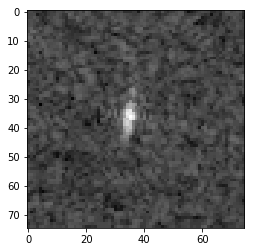

In [58]:
# Learning how to Manhandle the Data

# img = Image.fromarray(np.array(train_data[0]['band_1']))
img = train_data[0]['band_1']

# this is float data; saving as uint8 will kill info quality
# img = np.reshape(img, (75,75)).astype('uint8')
# img = Image.fromarray(img)
# img.save(PATH + TEST + 'test_band_1' + '.jpg') # jpg or png

np.save(PATH+TRAIN+'train_band_1', img)
img = np.load(PATH+TRAIN+'train_band_1.npy')

# img.shape # >>> (5625,)

img = np.reshape(img, (75,75))
# img.shape
visualize(img)

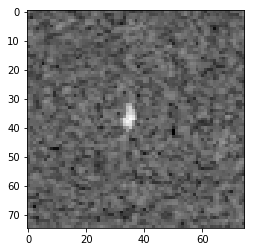

In [60]:
visualize(train_data[0]['band_2'], shape=(75,75))

In [74]:
# putting the images in folders, ignoring other data for now
for idx in range(len(train_data)):
    if train_data[idx]['is_iceberg'] == 1:
        CAT = 'ice/'
    else:
        CAT = 'ship/'
    # reshaping these bc I dont yet know how to get into correct format for ResNet later on
    np.save(PATH+TRAIN+CAT+'{:0=4d}_band_1.npy'.format(idx), np.reshape(train_data[idx]['band_1'], (75,75)))
    np.save(PATH+TRAIN+CAT+'{:0=4d}_band_2.npy'.format(idx), np.reshape(train_data[idx]['band_2'], (75,75)))

Training Data contains 851 Ships, 753 Icebergs

In [77]:
temp = np.load(PATH+TRAIN+'ship/'+'0000_band_1.npy'); temp

array([[-27.87836, -27.15416, -28.66861, ..., -25.57348, -26.48867, -30.50701],
       [-28.66853, -27.8784 , -27.50878, ..., -26.48863, -28.67156, -31.59417],
       [-28.66853, -27.15416, -25.86504, ..., -27.15711, -27.88139, -32.83712],
       ..., 
       [-29.0929 , -28.66916, -30.50461, ..., -30.01101, -25.86854, -26.48926],
       [-31.59168, -27.87899, -28.66921, ..., -27.51227, -26.81707, -27.51236],
       [-29.0929 , -26.81408, -27.15479, ..., -26.81703, -27.88198, -28.26813]])

In [159]:
# trying to get ImageClassifierData.from_paths to work; in the meantime, will try to use .from_arrays
train_data_array = []
train_labels_array = []

for datum in train_data:
    train_data_array.append(np.reshape(datum['band_1'], (1,75,75)))
    train_data_array.append(np.reshape(datum['band_2'], (1,75,75)))
    if datum['is_iceberg'] == 1:
        for i in range(2):
            train_labels_array.append(1)
    else:
        for i in range(2):
            train_labels_array.append(0)

train_data_array = np.array(train_data_array)
train_labels_array = np.array(train_labels_array)

Model

In [23]:
for datum in train_data:
    if datum['inc_angle'] == 'na':
        print(datum.keys())
        break

dict_keys(['id', 'band_1', 'band_2', 'inc_angle', 'is_iceberg'])


In [22]:
sz = 224
ARCH = resnet34

In [163]:
# I want to do this quick, & fastai API wants a val set, so I'm just passing train as val too
resnet_data = ImageClassifierData.from_arrays(PATH, (train_data_array, train_labels_array),
                                              (train_data_array, train_labels_array), bs=16)

In [149]:
# This did 1 iter the 1st time I ran it on (75,75) data; won't work at all, even if I resize
# data to (1,75,75) to try and mimic a single grayscale color channel
# learn = ConvLearner.pretrained(ARCH, resnet_data, precompute=True)

  0%|          | 0/201 [00:00<?, ?it/s]


RuntimeError: expected 3D tensor

In [139]:
array = np.random.random(9); array

array([ 0.73239,  0.14334,  0.73186,  0.94684,  0.32786,  0.81697,  0.22524,  0.76043,  0.48026])

In [140]:
array = np.reshape(array, (1,3,3)); array

array([[[ 0.73239,  0.14334,  0.73186],
        [ 0.94684,  0.32786,  0.81697],
        [ 0.22524,  0.76043,  0.48026]]])

In [141]:
array = np.expand_dims(array, 0); array

array([[[[ 0.73239,  0.14334,  0.73186],
         [ 0.94684,  0.32786,  0.81697],
         [ 0.22524,  0.76043,  0.48026]]]])

In [112]:
array.shape

(1, 3, 3)

In [134]:
array = np.reshape(array, (1,) + array.shape); array

array([[[ 0.22284,  0.26496,  0.83947],
        [ 0.63315,  0.87335,  0.93583],
        [ 0.91542,  0.5906 ,  0.45618]]])

In [135]:
array.shape

(1, 3, 3)

So be it; continuing without using the LR scheduler this time:

learn = ConvLearner.pretrained(ARCH, resnet_data)
learn.fit(0.01, 1)

Alright... so if the data is (75,75) .. then it's rejected bc it's not a 3D tensor. If it's (1,75,75) it's rejected due to `CUDNN_STATUS_BAD_PARAM`...

Either: I need to update my system's CUDA.. (could also check by running the cats v dogs fastai notebook to verify if it works/not) OR: something else is wrong. Heh either is likely.

In [ ]:
# np.rollaxis

I'm going to try something new here to troubleshoot the issue. Save the images as jpgs or pngs, and load them via `ImageClassifierData.from_paths`. If it works the issue has something to do with data shape.

In [ ]:
    if shape != None:
        float_matrix = np.reshape(float_matrix, shape)
        
    mat = np.copy(float_matrix)

    mat = mat - np.min(mat) if np.min(mat) < 0 else mat
    mat = np.round(255 * mat / np.max(mat)).astype(int)

    plt.imshow(mat, cmap='gray')

In [21]:
img = train_data[0]['band_1']
img = np.reshape(img, (75,75,1))

img

# plt.imshow(img, cmap='gray')
# img = visualize

array([[[-27.87836],
        [-27.15416],
        [-28.66861],
        ..., 
        [-25.57348],
        [-26.48867],
        [-30.50701]],

       [[-28.66853],
        [-27.8784 ],
        [-27.50878],
        ..., 
        [-26.48863],
        [-28.67156],
        [-31.59417]],

       [[-28.66853],
        [-27.15416],
        [-25.86504],
        ..., 
        [-27.15711],
        [-27.88139],
        [-32.83712]],

       ..., 
       [[-29.0929 ],
        [-28.66916],
        [-30.50461],
        ..., 
        [-30.01101],
        [-25.86854],
        [-26.48926]],

       [[-31.59168],
        [-27.87899],
        [-28.66921],
        ..., 
        [-27.51227],
        [-26.81707],
        [-27.51236]],

       [[-29.0929 ],
        [-26.81408],
        [-27.15479],
        ..., 
        [-26.81703],
        [-27.88198],
        [-28.26813]]])

In [16]:
# saving data as jpg images
for idx in range(len(train_data)):
    if train_data[idx]['is_iceberg'] == 1:
        CAT = 'ice/'
    else:
        CAT = 'ship/'
        
    img = np.reshape(train_data[idx]['band_1'], (75,75,1))
    img = Image.fromarray(img)
    img.save(PATH+TRAIN+CAT+'{:0=4d}_band_1.jpg'.format(idx))
    
    img = np.reshape(train_data[idx]['band_2'], (75,75,1))
    img = Image.fromarray(img)
    img.save(PATH+TRAIN+CAT+'{:0=4d}_band_2.jpg'.format(idx))

TypeError: Cannot handle this data type

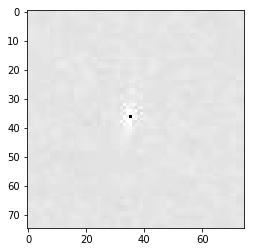

In [14]:
# testing what it'll look like and if I can open it
img = train_data[0]['band_1']
img = np.reshape(img, (75,75)).astype('uint8')
img = Image.fromarray(img)
img.save(PATH + 'test_band_1.jpg')
img = plt.imread(PATH + 'test_band_1.jpg')
plt.imshow(img, cmap='gray')

In [24]:
# Loading the data back into resnet
resnet_data = ImageClassifierData.from_paths(PATH, bs=16, val_name=None)

TypeError: join() argument must be str or bytes, not 'NoneType'

At this point, I'm thinking of testing whether I can get this thing to work at all with the Lesson 1 notebook, or just scrap it and build a model from scratch in Keras or PyTorch..

In [26]:
train = pd.read_json(PATH+TRAIN+'train.json')

In [28]:
train.head()

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


In [29]:
train.inc_angle = train.inc_angle.apply(lambda x: np.nan if x == 'na' else x)

In [36]:
img1 = train.loc[20, ['band_1', 'band_2']]

In [37]:
# 1st 2nd 3rd
img1 = np.stack([img1['band_1'], img1['band_2']], -1).reshape(75, 75, 2)

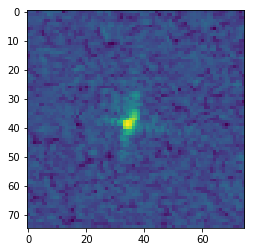

In [38]:
# band1
plt.imshow(img1[:, :, 0])

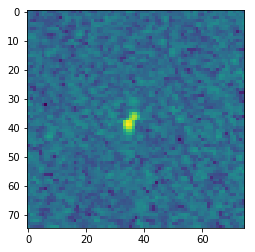

In [39]:
# band2
plt.imshow(img1[:,:,1])

In [40]:
combined = img1[:,:,0] / img1[:,:,1]

In [42]:
r = img1[:,:,0]
r = (r + abs(r.min())) / np.max((r + abs(r.min())))

g = img1[:,:,1]
g = (g + abs(g.min())) / np.max(g + abs(g.min()))

b = img1[:,:,0] / img1[:,:,1]
b = (((b) / np.max(b)) + abs((b) / np.max(b))) / np.max((((b) / np.max(b)) + abs((b) / np.max(b))))

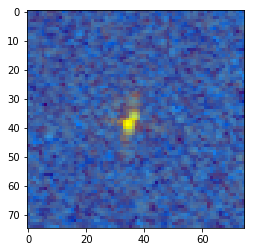

In [43]:
plt.imshow(np.dstack((r,g,b)))